In [1]:
for (pkg in c("ggplot2", "dplyr")) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}

In [2]:
color_pallete_for_dose <- c(
    "0.0" = "#85FF33",
    "0.61" = "#75FF1A",
    "1.22" = "#62FF00",
    "2.44" = "#4DC507",
    "4.88" = "#398E0B",
    "9.77" = "#265A0C",
    "19.53" = "#132B08",
    "39.06" = "#620B8E",
    "78.13" = "#410C5A",
    "156.25" = "#21082B"
)
font_size <- 24
plot_themes <- (
    theme_bw()
    + theme(
        legend.position = "bottom",
        legend.text = element_text(size = font_size),
        legend.title = element_text(size = font_size),
        axis.title.x = element_text(size = font_size),
        axis.text.x = element_text(size = font_size),
        axis.title.y = element_text(size = font_size),
        axis.text.y = element_text(size = font_size),
        strip.text = element_text(size = font_size -2),
    )
    
    
)

In [3]:
actual_results_file_path <- file.path("../../data/CP_aggregated/endpoints/aggregated_whole_image.parquet")
actual_results <- arrow::read_parquet(actual_results_file_path)
actual_results$Metadata_Time <- 13
actual_results$shuffled <- "FALSE"

# prepend Terminal to each non metadata column name
actual_results <- actual_results %>%
  rename_with(~ paste0("Terminal_", .), -c(Metadata_Time, Metadata_dose, Metadata_Well, shuffled))

columns_to_keep <- colnames(actual_results)



results_file_path <- file.path("../results/predicted_terminal_profiles_from_all_time_points.parquet")
results <- arrow::read_parquet(results_file_path)

subset_results <- results[, colnames(results) %in% columns_to_keep]


In [4]:
dim(actual_results)
dim(subset_results)

[1] 30 15

[1] 780  15

In [5]:

# merge the two dataframes on the columns "Metadata_Time" and "Metadata_dose" Metadata_Well
merged_results <- rbind(actual_results, subset_results)
merged_results$Metadata_Time <- as.numeric(merged_results$Metadata_Time) * 30
merged_results$shuffled <- gsub("TRUE", "Shuffled", merged_results$shuffled)
merged_results$shuffled <- gsub("FALSE", "Not shuffled", merged_results$shuffled)
merged_results$Metadata_dose <- as.numeric(merged_results$Metadata_dose)
merged_results$Metadata_dose <- factor(
    merged_results$Metadata_dose, 
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)


In [6]:

# map the train_test to the merged data
train_test_df <- results %>%
  select(Metadata_Well, Metadata_data_split) %>%
  distinct() %>%
  mutate(Metadata_data_split = gsub("train", "Train", Metadata_data_split)) %>%
  mutate(Metadata_data_split = gsub("test", "Test", Metadata_data_split)) %>%
  mutate(Metadata_data_split = gsub("validation", "Validation", Metadata_data_split))
# map the data split by well to the merged data
merged_results <- merged_results %>%
  left_join(train_test_df, by = c("Metadata_Well")) 
merged_results$Metadata_data_split <- gsub("non_Trained_pair", "Train", merged_results$Metadata_data_split)


In [7]:
# get the pca of the results
metadata_columns <- c("Metadata_Time", "Metadata_dose", "Metadata_Well", "shuffled", "Metadata_data_split")
# drop the metadata columns from the dataframe
pcadf <- merged_results[, !colnames(merged_results) %in% metadata_columns]

pca <- prcomp(pcadf, center = TRUE, scale. = TRUE)
# get the pca of the results
pca_df <- data.frame(pca$x)
pca_df$Metadata_Time <- merged_results$Metadata_Time
pca_df$Metadata_dose <- merged_results$Metadata_dose
pca_df$Metadata_Well <- merged_results$Metadata_Well
pca_df$Metadata_data_split <- merged_results$Metadata_data_split
pca_df$shuffled <- merged_results$shuffled
pca_df$Metadata_Time <- as.double((pca_df$Metadata_Time))
pca_df$Metadata_dose <- as.factor(pca_df$Metadata_dose)

pca_df$PC1 <- as.numeric(pca_df$PC1)
pca_df <- pca_df %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
pca_df <- pca_df %>% arrange(Group)
head(pca_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,Metadata_Time,Metadata_dose,Metadata_Well,Metadata_data_split,shuffled,Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,0.6364711,0.30165002,0.39918663,1.25316886,0.32145128,0.81805913,0.15978208,-0.01709201,-0.25537559,-0.188005729,-0.023796182,0,0,C-02,Test,Not shuffled,C-02
2,-0.7492592,-0.20264357,0.39870603,0.21073688,-0.24184470,0.12388065,0.08316552,-0.14291215,0.06985480,-0.348696512,0.137404925,0,0,C-02,Test,Shuffled,C-02
3,1.6950120,0.63873588,-0.03131600,0.34054136,0.31937267,0.35008139,-0.08394249,0.15017465,-0.54759109,-0.006419555,-0.024293280,30,0,C-02,Test,Not shuffled,C-02
4,-0.6972316,-0.04742481,0.16738072,0.11435764,0.16252067,0.04698931,-0.19397836,-0.34439613,0.02995308,-0.046340420,0.033019351,30,0,C-02,Test,Shuffled,C-02
5,2.2309296,0.58603495,-0.03957225,0.56436177,0.23185152,0.23996153,0.08142088,0.21054827,-0.25202602,-0.132964415,-0.002346381,60,0,C-02,Test,Not shuffled,C-02
6,-0.4948440,0.13194228,0.09328745,-0.06983682,0.05996297,0.18953460,-0.19944314,-0.25158282,0.55647374,-0.411169376,-0.002842961,60,0,C-02,Test,Shuffled,C-02


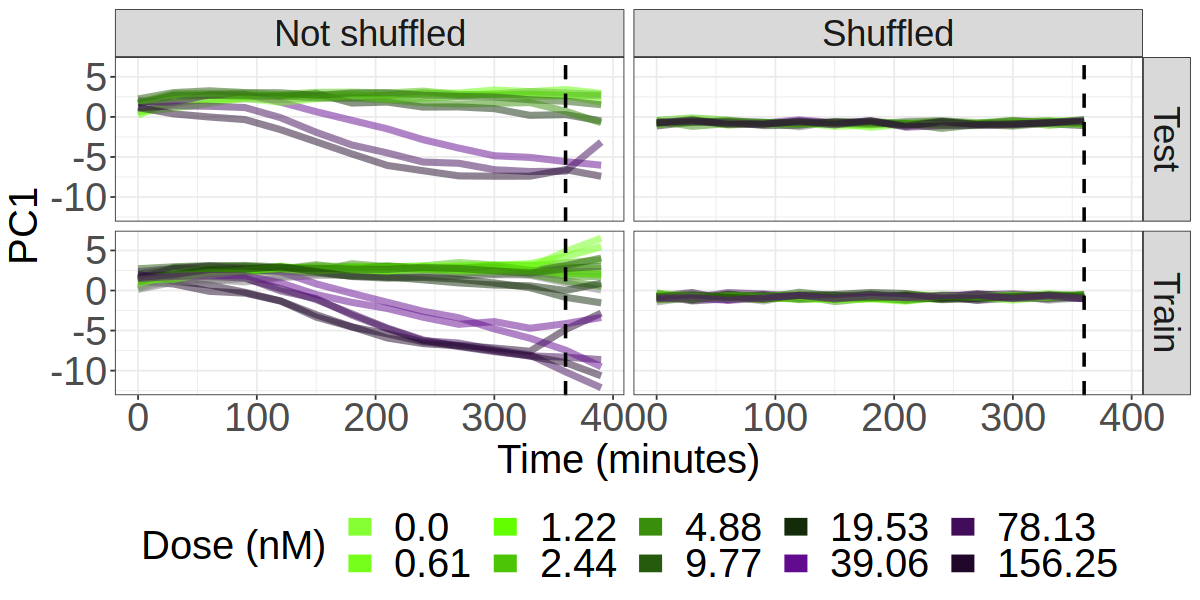

In [8]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca1_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC1, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC1", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))
)
ggsave(
    filename = "../figures/predicted_PC1.png",
    plot = pca1_plot,
    width = width,
    height = height,
    dpi = 600
)
pca1_plot

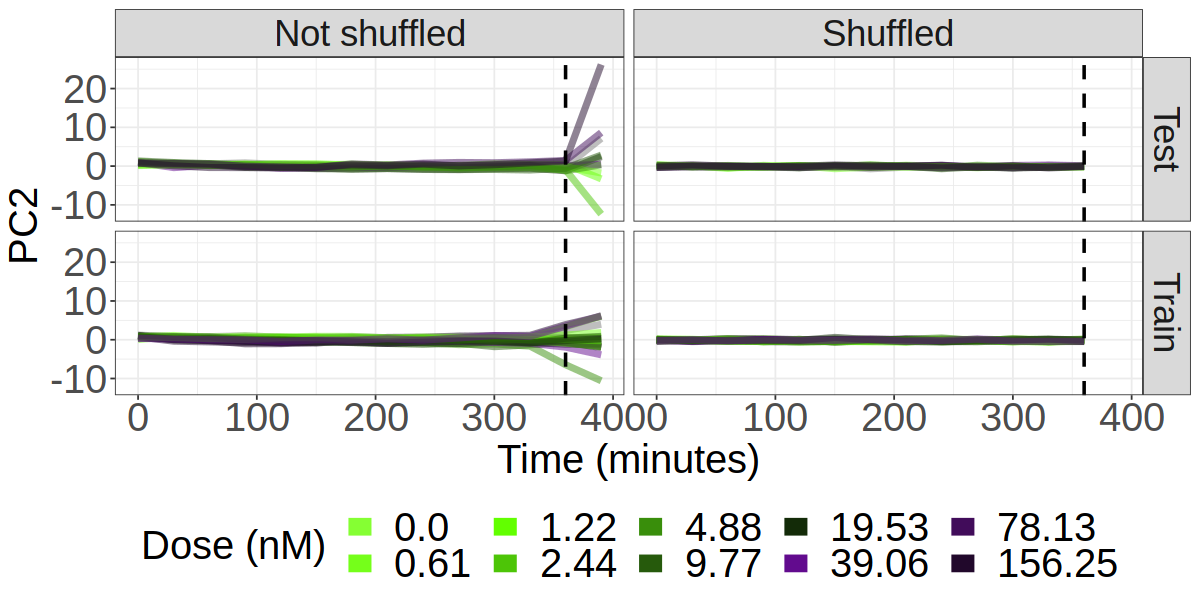

In [9]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca2_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC2, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC2", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))
)
ggsave(
    filename = "../figures/predicted_PC2.png",
    plot = pca2_plot,
    width = width,
    height = height,
    dpi = 600
)
pca2_plot

In [10]:
pca_df$Metadata_shuffle_plus_data_split <- paste0(pca_df$shuffled, "\n", pca_df$Metadata_data_split)
pca_df$Metadata_Time <- paste0(pca_df$Metadata_Time, " min.")

pca_df$Metadata_Time <- factor(
    pca_df$Metadata_Time, 
    levels = c(
        '0 min.',
        '30 min.',
        '60 min.',
        '90 min.',
        '120 min.',
        '150 min.',
        '180 min.',
        '210 min.',
        '240 min.',
        '270 min.',
        '300 min.',
        '330 min.',
        '360 min.',
        '390 min.'
    )
)
unique(pca_df$Metadata_Time)

[1] 0 min.   30 min.  60 min.  90 min.  120 min. 150 min. 180 min. 210 min.
 [9] 240 min. 270 min. 300 min. 330 min. 360 min. 390 min.
14 Levels: 0 min. 30 min. 60 min. 90 min. 120 min. 150 min. ... 390 min.

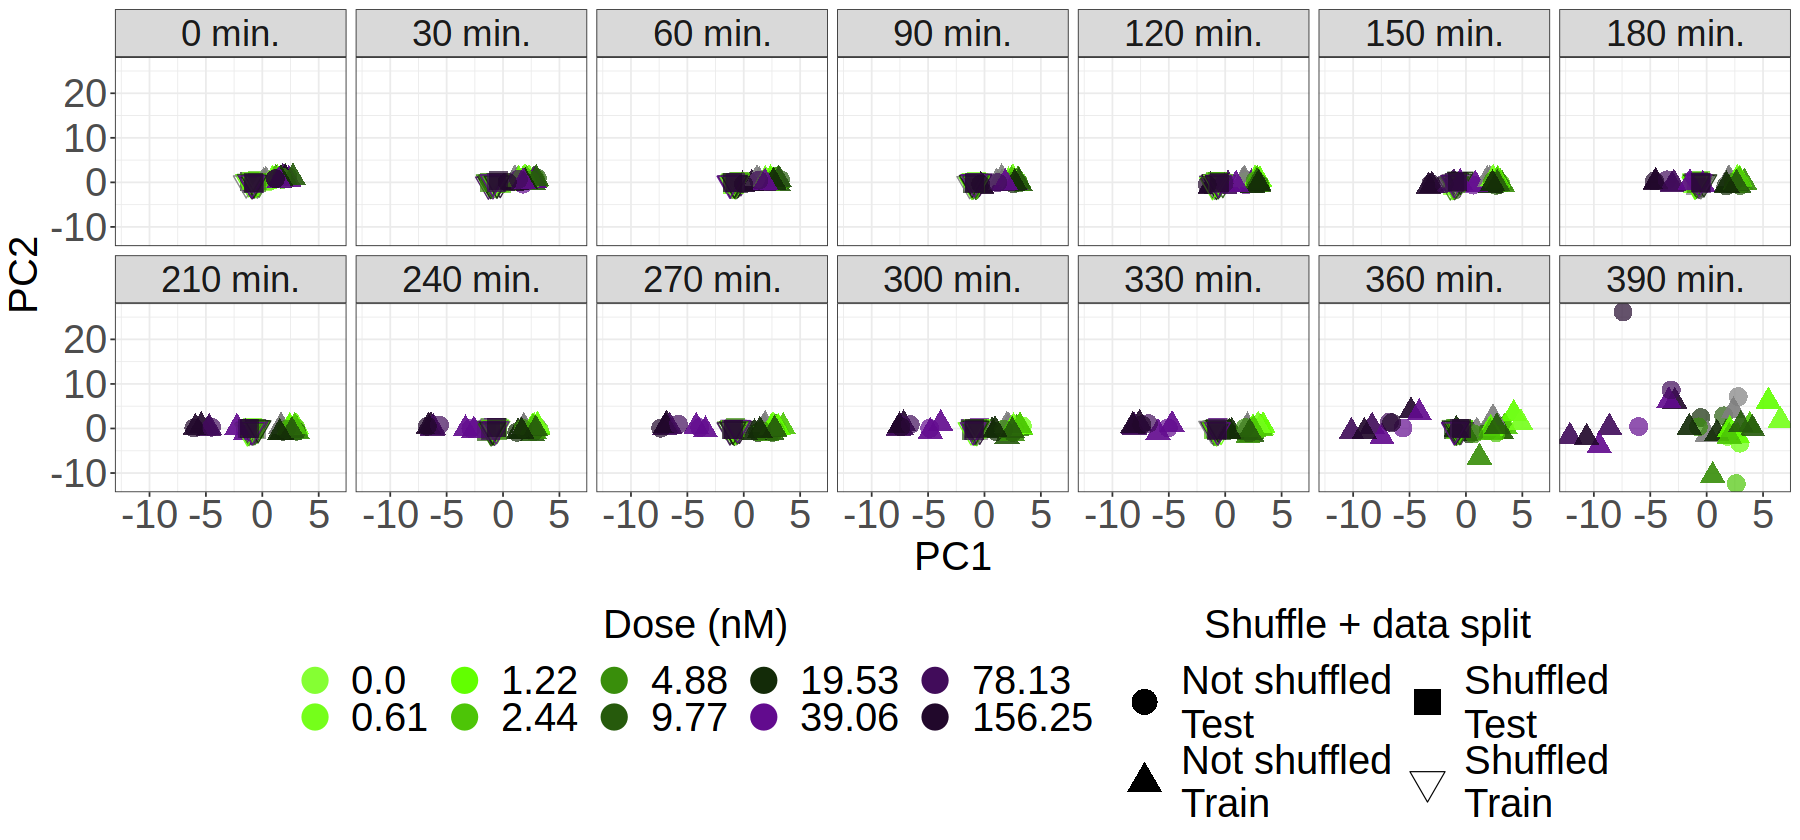

In [11]:
# plot PCA1 vs PCA2 over time
width <- 15
height <- 7
options(repr.plot.width=width, repr.plot.height=height)
pca_over_time_plot <- (
    ggplot(pca_df, aes(x = PC1, y = PC2, color = Metadata_dose))
    + geom_point(aes(shape = Metadata_shuffle_plus_data_split), size = 5, alpha = 0.7)
    + theme_minimal() 
    + facet_wrap( ~ Metadata_Time, ncol = 7)
    + labs(x="PC1", y="PC2", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + scale_shape_manual(values = c(16, 17,15,6), name = "Shuffle + data split")
    
    + guides(
        color = guide_legend(
            override.aes = list(size = 7, alpha = 1),
            title.position = "top",
            title.hjust = 0.5,
            ),
        shape = guide_legend(
            override.aes = list(size = 7, alpha = 1),
            title.position = "top",
            title.hjust = 0.5,
            nrow = 2,
        )
    )

)
ggsave(
    filename = "../figures/pca_over_time.png",
    plot = pca_over_time_plot,
    width = width,
    height = height,
    dpi = 600
)
pca_over_time_plot

In [12]:

# merged_results$Metadata_dose <- gsub('0', '0.0', merged_results$Metadata_dose)
unique(merged_results$Metadata_dose)
merged_results <- merged_results %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
merged_results <- merged_results %>% arrange(Group)
head(merged_results)

[1] 0      0.61   1.22   2.44   4.88   9.77   19.53  39.06  78.13  156.25
Levels: 0 0.61 1.22 2.44 4.88 9.77 19.53 39.06 78.13 156.25

Metadata_Well,Metadata_dose,Terminal_Intensity_LowerQuartileIntensity_AnnexinV,Terminal_Intensity_MADIntensity_AnnexinV,Terminal_Intensity_MADIntensity_DNA,Terminal_Intensity_MaxIntensity_AnnexinV,Terminal_Intensity_MaxIntensity_DNA,Terminal_Intensity_MeanIntensity_AnnexinV,Terminal_Intensity_MeanIntensity_DNA,Terminal_Intensity_StdIntensity_AnnexinV,Terminal_Intensity_StdIntensity_DNA,Terminal_Intensity_UpperQuartileIntensity_AnnexinV,Terminal_Intensity_UpperQuartileIntensity_DNA,Metadata_Time,shuffled,Metadata_data_split,Group
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
C-02,0,0.03015051,-0.6363698,8.010986e-07,-0.4517316,0.09468088,0.54450303,0.5810192,0.2996676,1.1802845,-0.10099895,-0.4533981,0,Not shuffled,Test,C-02
C-02,0,-0.06700471,-1.7265045,8.010986e-07,-0.5094460,0.30740230,0.65637119,0.7549747,0.3735022,2.1086498,-0.18904708,-0.5705785,0,Shuffled,Test,C-02
C-02,0,0.09999386,-0.4172084,5.493248e-07,-0.4189054,0.18087391,0.01000582,0.3560168,0.1538301,0.6642228,-0.30462446,-0.3226968,30,Not shuffled,Test,C-02
C-02,0,-0.02655811,-1.5372661,6.179904e-07,-0.5040783,0.33170595,0.69999448,0.6503513,0.4613944,2.1318935,-0.05655778,-0.4876508,30,Shuffled,Test,C-02
C-02,0,0.14961391,-0.3752011,5.798428e-07,-0.4156131,0.13100317,-0.03251243,0.3578602,-0.1025287,0.5547995,-0.45455654,-0.2226428,60,Not shuffled,Test,C-02
C-02,0,-0.08389220,-1.6929644,6.027314e-07,-0.4662032,0.31897430,0.73874556,0.5516693,0.1532062,2.2140653,-0.18988130,-0.4831439,60,Shuffled,Test,C-02


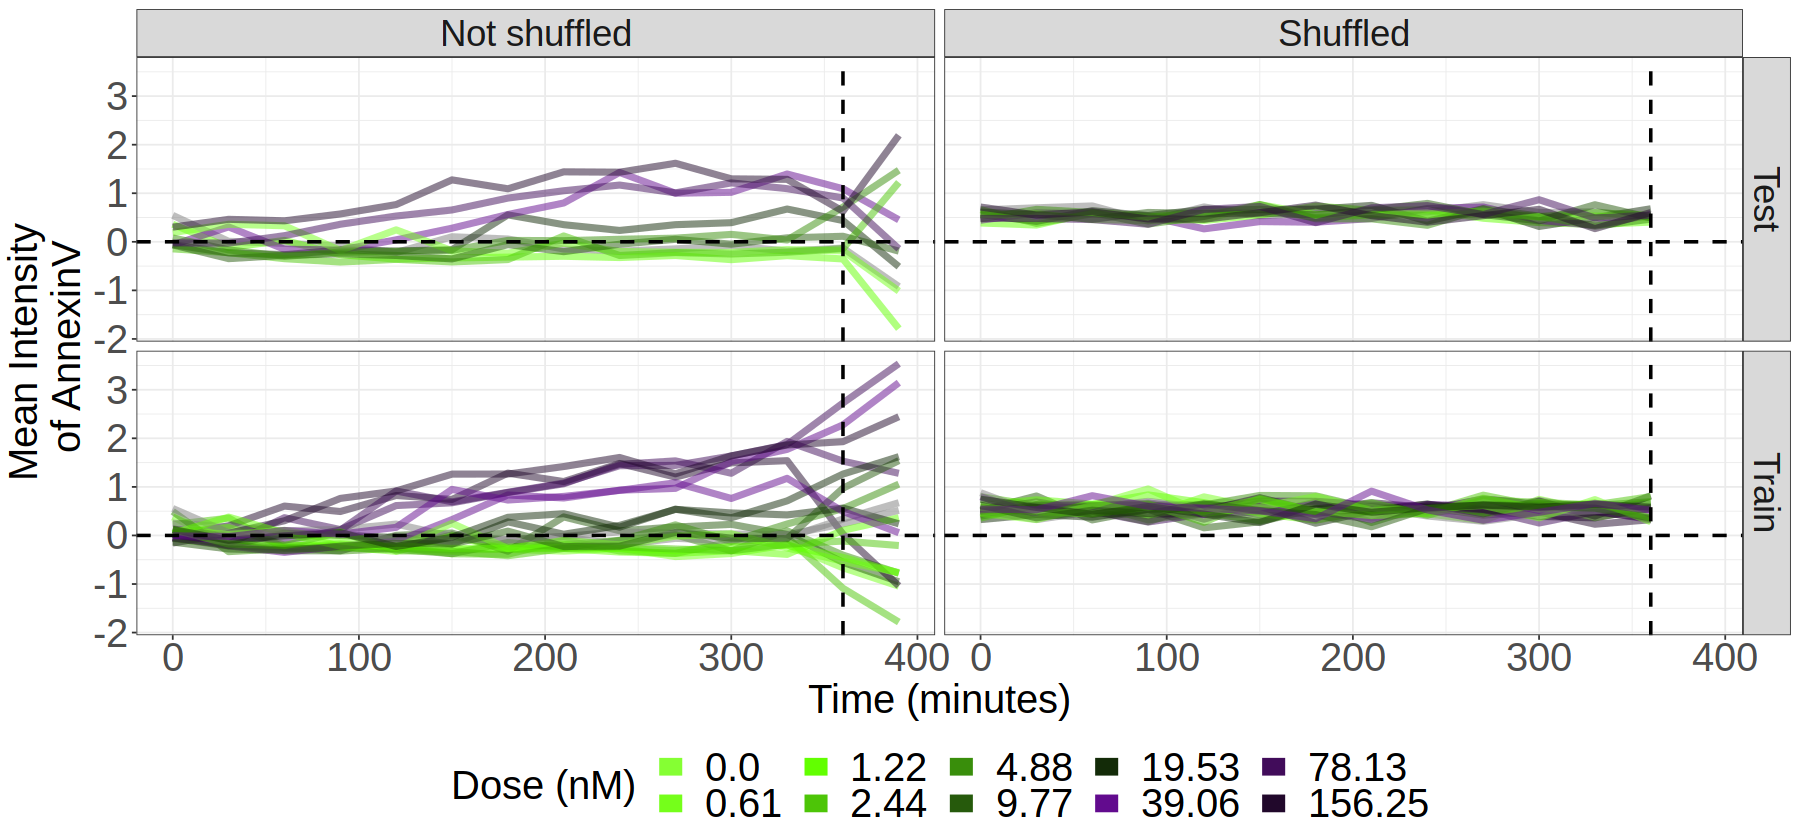

In [13]:
# plot the pca
feature_plot <- (
    ggplot(merged_results, aes(x = Metadata_Time, y = Terminal_Intensity_MeanIntensity_AnnexinV, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)

    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 1)

    + labs(x="Time (minutes)", y="Mean Intensity \nof AnnexinV", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))


)
ggsave(
    filename = "../figures/predicted_Terminal_Intensity_MeanIntensity_AnnexinV.png",
    plot = feature_plot,
    width = width,
    height = height,
    dpi = 600
)
feature_plot